In [32]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("IBM", start="2019-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed


In [33]:
df.shape


(1258, 6)

In [34]:
reversed_df = df.iloc[::-1]

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features_fwd = scaler.fit_transform(df) 
scaled_features_bkwd = scaler.fit_transform(reversed_df) 

In [36]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
predicition_length = 1
X_fwd, y_fwd = create_sequences(scaled_features_fwd, seq_length,predicition_length)
X_bkwd, y_bkwd = create_sequences(scaled_features_bkwd, seq_length, predicition_length)

In [37]:
split_fraction = 0.8
split = int(split_fraction * len(X_fwd))

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [38]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64  

#Forward
train_data = TensorDataset(torch.Tensor(X_train_fwd), torch.Tensor(y_train_fwd))
train_loader_fwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_fwd), torch.Tensor(y_test_fwd))
test_loader_fwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#Backward
train_data = TensorDataset(torch.Tensor(X_train_bkwd), torch.Tensor(y_train_bkwd))
train_loader_bkwd = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test_bkwd), torch.Tensor(y_test_bkwd))
test_loader_bkwd = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## Simple RNN

In [39]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [40]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader):
    loss_values =[]
    model.train()
    
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
    
        loss_values.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_values

### Forward and Backward Training

Running on CPU
Epoch [1/100], Loss: 0.4284
Epoch [2/100], Loss: 0.3440
Epoch [3/100], Loss: 0.1665
Epoch [4/100], Loss: 0.1651
Epoch [5/100], Loss: 0.1142
Epoch [6/100], Loss: 0.1130
Epoch [7/100], Loss: 0.0823
Epoch [8/100], Loss: 0.0278
Epoch [9/100], Loss: 0.0465
Epoch [10/100], Loss: 0.0375
Epoch [11/100], Loss: 0.0381
Epoch [12/100], Loss: 0.0089
Epoch [13/100], Loss: 0.0140
Epoch [14/100], Loss: 0.0196
Epoch [15/100], Loss: 0.0205
Epoch [16/100], Loss: 0.0332
Epoch [17/100], Loss: 0.0177
Epoch [18/100], Loss: 0.0156
Epoch [19/100], Loss: 0.0225
Epoch [20/100], Loss: 0.0179
Epoch [21/100], Loss: 0.0158
Epoch [22/100], Loss: 0.0219
Epoch [23/100], Loss: 0.0249
Epoch [24/100], Loss: 0.0253
Epoch [25/100], Loss: 0.0125
Epoch [26/100], Loss: 0.0390
Epoch [27/100], Loss: 0.0245
Epoch [28/100], Loss: 0.0157
Epoch [29/100], Loss: 0.0268
Epoch [30/100], Loss: 0.0345
Epoch [31/100], Loss: 0.0264
Epoch [32/100], Loss: 0.0248
Epoch [33/100], Loss: 0.0170
Epoch [34/100], Loss: 0.0136
Epoch [3

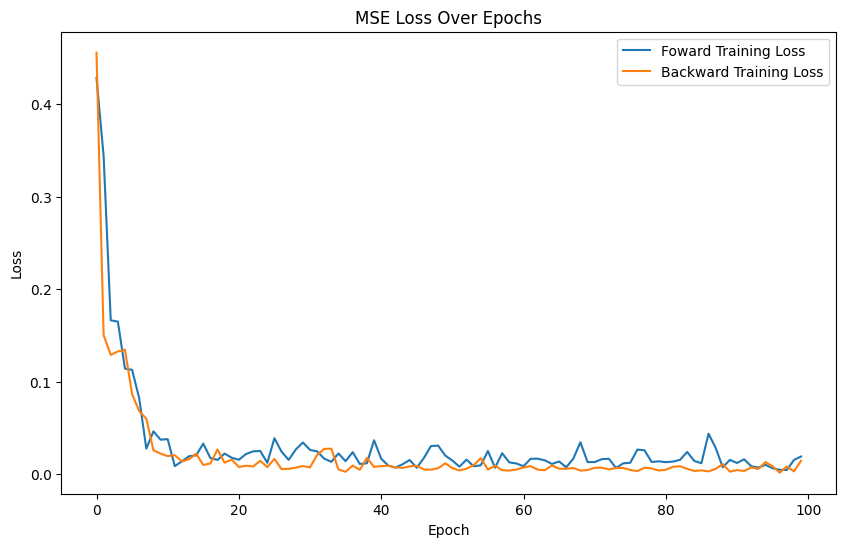

In [43]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

# Forward Model Initialization and Training 
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

loss_values_fwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd
              )

# Backward Model Initialization and Training
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

loss_values_bkwd = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd, label='Foward Training Loss')
plt.plot(loss_values_bkwd, label='Backward Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## Transformer

In [10]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size)  # Assuming input is already a feature vector
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  # Output is a single value
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  # Ensure input is properly sized
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [12]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/christopherguarino/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss for this epoch
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_val_loss += val_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  # Store validation loss for this epoch

        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses  # Return the loss lists for plotting


In [27]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

Epoch [1/100]: Train Loss: 0.8356, Val Loss: 3.7569
Epoch [2/100]: Train Loss: 0.6169, Val Loss: 3.5297
Epoch [3/100]: Train Loss: 0.5586, Val Loss: 3.2472
Epoch [4/100]: Train Loss: 0.4949, Val Loss: 3.0426
Epoch [5/100]: Train Loss: 0.4290, Val Loss: 2.9949
Epoch [6/100]: Train Loss: 0.3944, Val Loss: 2.7594
Epoch [7/100]: Train Loss: 0.3504, Val Loss: 2.8395
Epoch [8/100]: Train Loss: 0.3358, Val Loss: 2.6462
Epoch [9/100]: Train Loss: 0.3103, Val Loss: 2.4574
Epoch [10/100]: Train Loss: 0.3135, Val Loss: 2.5983
Epoch [11/100]: Train Loss: 0.3088, Val Loss: 2.3209
Epoch [12/100]: Train Loss: 0.2916, Val Loss: 2.1404
Epoch [13/100]: Train Loss: 0.2776, Val Loss: 2.1364
Epoch [14/100]: Train Loss: 0.2855, Val Loss: 2.0574
Epoch [15/100]: Train Loss: 0.2808, Val Loss: 1.9656
Epoch [16/100]: Train Loss: 0.2682, Val Loss: 2.0720
Epoch [17/100]: Train Loss: 0.2385, Val Loss: 1.8104
Epoch [18/100]: Train Loss: 0.2473, Val Loss: 1.9211
Epoch [19/100]: Train Loss: 0.2329, Val Loss: 1.8366
Ep

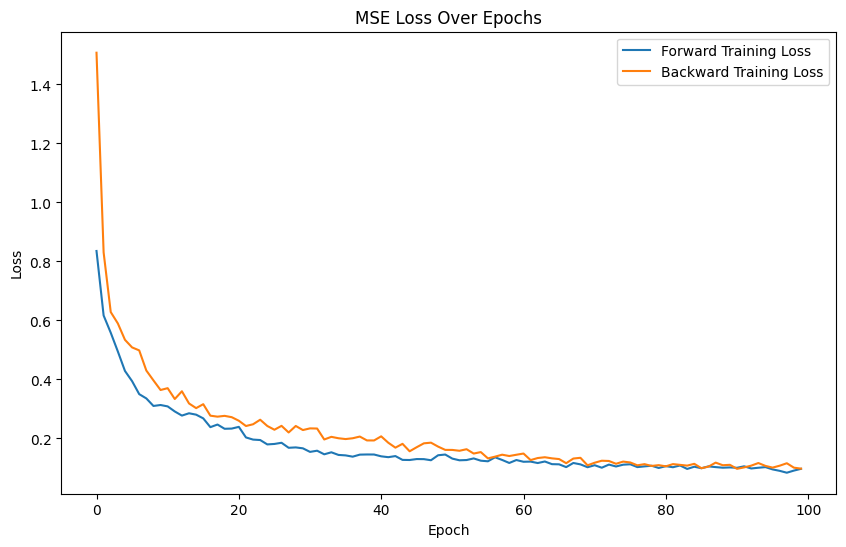

In [31]:
import matplotlib.pyplot as plt

# Assuming train_model has been called and returned loss values for both forward and backward training
model.apply(reset_weights)  # Reset model weights
loss_values_fwd_train, loss_values_fwd_val = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs=100)
model.apply(reset_weights)  # Reset model weights
loss_values_bkwd_train, loss_values_bkwd_val = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs=100)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()
